In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
#from cartiflette.s3 import download_vectorfile_url_all
from scipy.stats import binom
from sklearn.linear_model import LinearRegression

In [3]:
# Collecte des données
data=pd.read_csv("Donnees-sur-le-parc-de-vehicule-au-niveau-regional.2023-05.csv", sep=';',header=[1])

# A - Statistiques descriptives

Merci pour toutes ces analyses Théo c'est grv propre ! Maintenant on peut se poser la question de "qu'est-ce qu'on garde comme Stats desc pour le code final ?". Je pense que tes graphes sur l'évolution du nombre de véhicule par carburant et par critère sont super, et il faut clairement les avoir. Sinon, je pense aussi (on peut en discuter) :

- Ajouter quelque chose du genre évolution du nombre de véhicules ayant été mis sur le marché la même année (je pourrai le faire ce we je pense), pour voir comment ils tombent en panne ou ils sont remplacés.
- Evolution des proportions de Crit'Air et de carburant pour les véhicules neufs.
- Evolution de l'âge moyen des voitures, peut être par carburant.

Aussi, tes graphes sur les taux de croissances sont nickel, il faut clairement les avoir.

D'ailleurs, je pense qu'on peut éliminer dès maintenant les véhicules autres que les véhicules particulier, avec : 

```python
data = data.loc[data["CATEGORIE_VEHICULE"] == "Véhicule particulier"]
```

In [4]:
data.head()

,REGION_CODE,REGION_LIBELLE,CLASSE_VEHICULE,CATEGORIE_VEHICULE,CARBURANT,AGE,STATUT_UTILISATEUR,CRITAIR,PARC_2011,PARC_2012,PARC_2013,PARC_2014,PARC_2015,PARC_2016,PARC_2017,PARC_2018,PARC_2019,PARC_2020,PARC_2021,PARC_2022
0,84,Auvergne-Rhône-Alpes,tcp,Autobus,Diesel,0 an,Professionnel,Crit'Air 2,0,0,0,4,74,188,175,253,178,162,85,32
1,84,Auvergne-Rhône-Alpes,tcp,Autocar,Diesel,0 an,Professionnel,Crit'Air 2,0,0,0,9,436,644,644,693,556,709,383,331
2,84,Auvergne-Rhône-Alpes,tcp,Autobus,Diesel,0 an,Professionnel,Crit'Air 3,187,182,223,178,43,4,3,0,0,0,0,0
3,84,Auvergne-Rhône-Alpes,tcp,Autocar,Diesel,0 an,Professionnel,Crit'Air 3,487,552,500,713,194,20,2,2,0,0,0,0
4,84,Auvergne-Rhône-Alpes,tcp,Autobus,Diesel,0 an,Professionnel,Crit'Air 4,1,1,0,0,0,0,0,0,0,0,0,0


In [5]:
data.describe()

,PARC_2011,PARC_2012,PARC_2013,PARC_2014,PARC_2015,PARC_2016,PARC_2017,PARC_2018,PARC_2019,PARC_2020,PARC_2021,PARC_2022
count,59249.000000,59249.000000,59249.000000,59249.000000,59249.000000,59249.000000,59249.00000,59249.000000,59249.000000,59249.000000,59249.000000,59249.000000
mean,698.935746,704.991477,710.407247,718.305440,728.575048,739.211092,749.85512,760.416176,763.678644,766.328934,766.911036,771.795372
std,6016.875130,6138.360312,6238.653362,6327.022692,6425.416904,6502.896366,6563.84284,6610.401049,6628.078434,6669.778939,6638.786109,6576.901827
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.00000,8.000000,8.000000,6.000000,6.000000,7.000000
max,186182.000000,189798.000000,193089.000000,197010.000000,198035.000000,197957.000000,194802.00000,190144.000000,189265.000000,186764.000000,183740.000000,194366.000000


In [6]:
# Visualisation du nombre de véhicule chaque année:
data.groupby('CATEGORIE_VEHICULE')[['PARC_2011','PARC_2012','PARC_2013','PARC_2014','PARC_2015','PARC_2017','PARC_2018','PARC_2019','PARC_2020','PARC_2021','PARC_2022']].sum()

,PARC_2011,PARC_2012,PARC_2013,PARC_2014,PARC_2015,PARC_2017,PARC_2018,PARC_2019,PARC_2020,PARC_2021,PARC_2022
CATEGORIE_VEHICULE,,,,,,,,,,,
Autobus,19935,20379,20567,21261,21445,21857,22208,23798,25039,26399,27927
Autocar,63538,64507,64562,65313,65539,66658,67249,66972,67258,66519,66596
Autre VASP,111407,112299,115030,116821,119137,125604,130150,132851,135047,141331,148602
Camion,317242,319386,314912,311576,308993,305086,307067,306356,306208,304688,307385
Camionnette,4197919,4278148,4337506,4421633,4508317,4679694,4798184,4857367,4823739,4831151,4868001
Camping-car,299354,315358,328242,341066,354094,383908,399781,415555,431637,449049,473771
Dérivé VP,831826,844830,850112,859212,869492,891033,903609,900248,875600,835900,788506
Tracteur routier,198031,199745,195227,194017,192090,198194,205362,213177,217796,216157,219795
VASP lourd,72433,75135,76914,78750,80353,82656,83470,84440,85981,87013,89125


Nous pouvons voir que le nombre de véhicule par catégorie reste relativement identique au cours des années

In [8]:
# Visualisation du nombre de Crit'Air chaque année:
data.groupby('CRITAIR')[['PARC_2011','PARC_2012','PARC_2013','PARC_2014','PARC_2015','PARC_2016','PARC_2017','PARC_2018','PARC_2019','PARC_2020','PARC_2021','PARC_2022']].sum()

,PARC_2011,PARC_2012,PARC_2013,PARC_2014,PARC_2015,PARC_2016,PARC_2017,PARC_2018,PARC_2019,PARC_2020,PARC_2021,PARC_2022
CRITAIR,,,,,,,,,,,,
Crit'Air 1,546749,1138570,1652291,2237190,2874290,3664024,4617077,5744989,7113116,8587016,9725156,10946974
Crit'Air 2,3826368,5574126,7348515,8968353,10527295,11963735,13325544,14585321,15697826,16791261,17506252,17935698
Crit'Air 3,15058944,15043085,14744201,14442758,14130516,13797632,13384454,12894875,12249017,11539424,10786515,10053194
Crit'Air 4,7296685,7142718,6986207,6816882,6637426,6401865,6109626,5752477,5257681,4660227,4136723,3695476
Crit'Air 5,3115706,2986255,2836056,2674410,2507735,2322394,2122131,1915600,1665346,1379434,1140407,986711
Crit'Air E,4656,8097,16115,28302,40755,60884,85552,111862,142563,183817,295053,463817
Inconnu,1769,1891,2012,2099,2108,2241,2390,2532,2487,2418,2333,2161
Non classé,11560367,9875298,8505522,7388885,6447218,5584743,4781392,4046242,3119160,2260626,1846273,1644073


En revanche la "qualité" (au niveau de la pollution) s'est très largement améliorée. Le nombre de "bons" crit'air a augmenté tandis que celui des "mauvais" a diminué.

In [10]:
# Regrouper les vignettes critair entre elles dans chaque régions pour ensuite pouvoir avoir le nombre de véhicules
# par critair, par régions
result2 = data.groupby(['REGION_LIBELLE','CRITAIR'])[['PARC_2011','PARC_2012','PARC_2013','PARC_2014','PARC_2015','PARC_2016','PARC_2017','PARC_2018','PARC_2019','PARC_2020','PARC_2021','PARC_2022']].sum().reset_index()
result2.head()

,REGION_LIBELLE,CRITAIR,PARC_2011,PARC_2012,PARC_2013,PARC_2014,PARC_2015,PARC_2016,PARC_2017,PARC_2018,PARC_2019,PARC_2020,PARC_2021,PARC_2022
0,Auvergne-Rhône-Alpes,Crit'Air 1,64680,137594,204870,283212,366715,469623,592450,743477,920868,1108861,1264439,1425480
1,Auvergne-Rhône-Alpes,Crit'Air 2,467792,689319,921805,1136664,1340438,1524958,1700960,1869637,2020462,2163276,2256674,2312674
2,Auvergne-Rhône-Alpes,Crit'Air 3,1889358,1906778,1876080,1838575,1797508,1753510,1697612,1630179,1547183,1450588,1349059,1251804
3,Auvergne-Rhône-Alpes,Crit'Air 4,928880,908508,886239,859825,832681,798930,758053,709610,646692,568745,500487,445183
4,Auvergne-Rhône-Alpes,Crit'Air 5,384118,365950,345082,321806,299093,274865,249390,223215,193842,159223,130280,113133


In [11]:
result3 = data.groupby(['REGION_LIBELLE','CRITAIR','CARBURANT'])[['PARC_2011','PARC_2012','PARC_2013','PARC_2014','PARC_2015','PARC_2016','PARC_2017','PARC_2018','PARC_2019','PARC_2020','PARC_2021','PARC_2022']].sum().reset_index()
result3.head()

,REGION_LIBELLE,CRITAIR,CARBURANT,PARC_2011,PARC_2012,PARC_2013,PARC_2014,PARC_2015,PARC_2016,PARC_2017,PARC_2018,PARC_2019,PARC_2020,PARC_2021,PARC_2022
0,Auvergne-Rhône-Alpes,Crit'Air 1,Diesel,1,2,3,7,6,8,6,5,3,3,2,1
1,Auvergne-Rhône-Alpes,Crit'Air 1,Diesel HNR,0,0,0,0,0,0,1,1,0,1,1,0
2,Auvergne-Rhône-Alpes,Crit'Air 1,Electrique et hydrogène,0,1,1,1,1,2,0,0,0,0,0,0
3,Auvergne-Rhône-Alpes,Crit'Air 1,Essence,39400,110360,176283,251200,331709,430897,548591,690186,855450,1030717,1156377,1260233
4,Auvergne-Rhône-Alpes,Crit'Air 1,Essence HNR,337,437,1872,5261,8552,11991,16905,24862,35525,46400,64470,97034


## Évolution du nombre de véhicules en fonction du carburant

In [12]:
result1 = data.groupby(['CARBURANT'])[['PARC_2011','PARC_2012','PARC_2013','PARC_2014','PARC_2015','PARC_2016','PARC_2017','PARC_2018','PARC_2019','PARC_2020','PARC_2021','PARC_2022']].sum().reset_index()

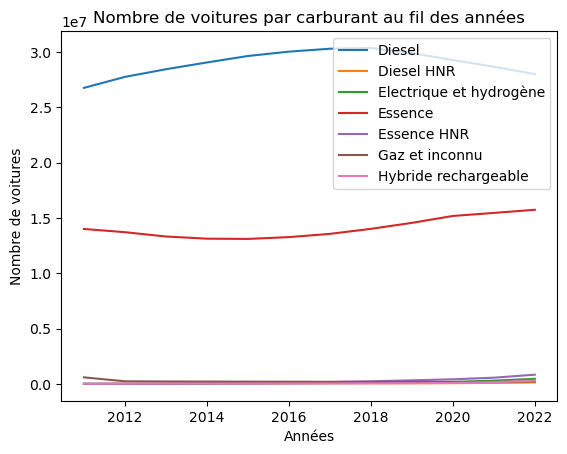

In [13]:
Années=[2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022]
i=0
v=result1.iloc[0]
v=v[1:]
for c in result1['CARBURANT']:
    v=result1.iloc[i]
    v=v[1:]
    plt.plot(Années,v, label=c)
    i+=1

# Ajout des titres et légendes
plt.title('Nombre de voitures par carburant au fil des années')
plt.xlabel('Années')
plt.ylabel('Nombre de voitures')
plt.legend()
plt.show()

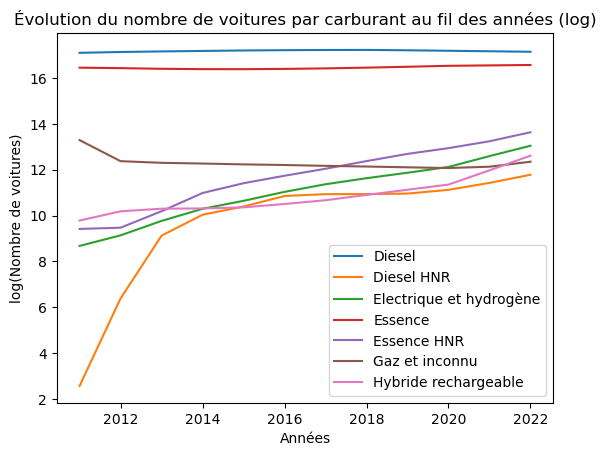

In [14]:
#Nous allons faire un passage au log pour enlever les effets d'échelles:
# Choisir les variables que l'on souhaite passer au logarithme
variables_a_logarithmer = ['PARC_2011','PARC_2012','PARC_2013','PARC_2014','PARC_2015','PARC_2016','PARC_2017','PARC_2018','PARC_2019','PARC_2020','PARC_2021','PARC_2022']

# Appliquez le logarithme à toutes les variables sélectionnées
result1[variables_a_logarithmer] = np.log(result1[variables_a_logarithmer])

v=result1.iloc[0]
v=v[1:]
Années=[2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022]
i=0
for c in result1['CARBURANT']:
    v=result1.iloc[i]
    v=v[1:]
    plt.plot(Années,v, label=c)
    i+=1

# Ajout des titres et légendes
plt.title('Évolution du nombre de voitures par carburant au fil des années (log)')
plt.xlabel('Années')
plt.ylabel('log(Nombre de voitures)')
plt.legend()
plt.show()

## Évolution du nombre de véhicules

In [15]:
def nb_vehicules(data):
    annees={'Années':[2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022]}
    annees=pd.DataFrame(annees)
    nb={'Nombre_Vehicules':[]}
    n=[]
    for k in range (11,23):
        n.append(data[f'PARC_20{k}'].sum())
    nb['Nombre_Vehicules']=n
    nb=pd.DataFrame(nb)
    df=pd.concat([annees,nb],axis=1)
    return df

In [16]:
df=nb_vehicules(data)
df

,Années,Nombre_Vehicules
0,2011,41411244
1,2012,41770040
2,2013,42090919
3,2014,42558879
4,2015,43167343
5,2016,43797518
6,2017,44428166
7,2018,45053898
8,2019,45247196
9,2020,45404223


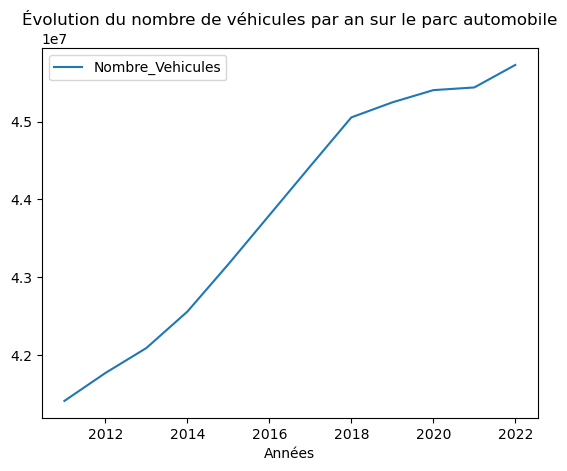

In [17]:
n=nb_vehicules(data).copy()
n=n.set_index('Années')
n.plot()
plt.title("Évolution du nombre de véhicules par an sur le parc automobile")
plt.show()

In [18]:
df['Taux de croissance'] = ((df['Nombre_Vehicules'] - df['Nombre_Vehicules'].shift(1)) / df['Nombre_Vehicules'].shift(1)) * 100
print(f"Le taux de croissance moyen (tout véhicules confondus) est de : {df['Taux de croissance'].mean()}")

Le taux de croissance moyen (tout véhicules confondus) est de : 0.906654946649314


In [19]:
df

,Années,Nombre_Vehicules,Taux de croissance
0,2011,41411244,NaN
1,2012,41770040,0.866422
2,2013,42090919,0.768204
3,2014,42558879,1.111784
4,2015,43167343,1.429699
5,2016,43797518,1.459842
6,2017,44428166,1.439917
7,2018,45053898,1.408413
8,2019,45247196,0.429037
9,2020,45404223,0.347042


## Évolution du nombre de voitures par crit'air

In [20]:
#Nous allons maintenant regarder la croissance de manière plus précise en regardant celle-ci pour chaque crit'air

In [21]:
result_crit = data.groupby(['CRITAIR'])[['PARC_2011','PARC_2012','PARC_2013','PARC_2014','PARC_2015','PARC_2016','PARC_2017','PARC_2018','PARC_2019','PARC_2020','PARC_2021','PARC_2022']].sum().reset_index()
result_crit

,CRITAIR,PARC_2011,PARC_2012,PARC_2013,PARC_2014,PARC_2015,PARC_2016,PARC_2017,PARC_2018,PARC_2019,PARC_2020,PARC_2021,PARC_2022
0,Crit'Air 1,546749,1138570,1652291,2237190,2874290,3664024,4617077,5744989,7113116,8587016,9725156,10946974
1,Crit'Air 2,3826368,5574126,7348515,8968353,10527295,11963735,13325544,14585321,15697826,16791261,17506252,17935698
2,Crit'Air 3,15058944,15043085,14744201,14442758,14130516,13797632,13384454,12894875,12249017,11539424,10786515,10053194
3,Crit'Air 4,7296685,7142718,6986207,6816882,6637426,6401865,6109626,5752477,5257681,4660227,4136723,3695476
4,Crit'Air 5,3115706,2986255,2836056,2674410,2507735,2322394,2122131,1915600,1665346,1379434,1140407,986711
5,Crit'Air E,4656,8097,16115,28302,40755,60884,85552,111862,142563,183817,295053,463817
6,Inconnu,1769,1891,2012,2099,2108,2241,2390,2532,2487,2418,2333,2161
7,Non classé,11560367,9875298,8505522,7388885,6447218,5584743,4781392,4046242,3119160,2260626,1846273,1644073


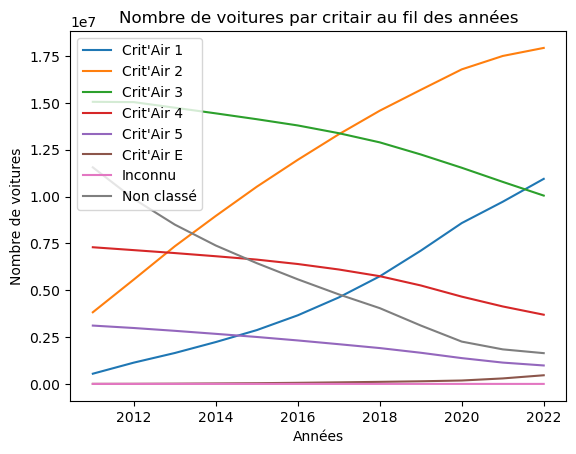

In [22]:
i=0
Années=[2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022]
v=result_crit.iloc[0]
v=v[1:]
for c in result_crit['CRITAIR']:
    v=result_crit.iloc[i]
    v=v[1:]
    plt.plot(Années,v, label=c)
    i+=1

# Ajout des titres et légendes
plt.title('Nombre de voitures par critair au fil des années')
plt.xlabel('Années')
plt.ylabel('Nombre de voitures')
plt.legend()
plt.show()

In [23]:
#Nous allons refaire la même chose que pour le carburant en passant au log.

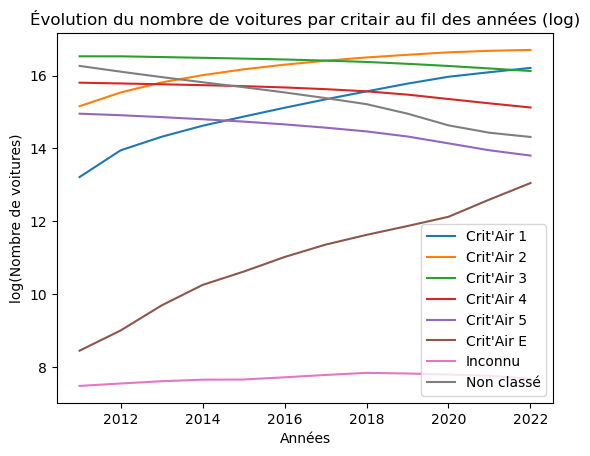

In [24]:
# Choisir les variables que l'on souhaite passer au logarithme
variables_a_logarithmer = ['PARC_2011','PARC_2012','PARC_2013','PARC_2014','PARC_2015','PARC_2016','PARC_2017','PARC_2018','PARC_2019','PARC_2020','PARC_2021','PARC_2022']

# Appliquez le logarithme à toutes les variables sélectionnées
result_crit[variables_a_logarithmer] = np.log(result_crit[variables_a_logarithmer])

v=result_crit.iloc[0]
v=v[1:]
Années=[2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022]
i=0
for c in result_crit['CRITAIR']:
    v=result_crit.iloc[i]
    v=v[1:]
    plt.plot(Années,v, label=c)
    i+=1

# Ajout des titres et légendes
plt.title('Évolution du nombre de voitures par critair au fil des années (log)')
plt.xlabel('Années')
plt.ylabel('log(Nombre de voitures)')
plt.legend()
plt.show()

## Taux de croissance en fonction des crit'air

In [25]:
#Nous allons maintenant nous intéresser au taux de croissance moyen pour chaque critair.
result = data.groupby(['CRITAIR'])[['PARC_2011','PARC_2012','PARC_2013','PARC_2014','PARC_2015','PARC_2016','PARC_2017','PARC_2018','PARC_2019','PARC_2020','PARC_2021','PARC_2022']].sum().reset_index()
result=result.set_index('CRITAIR')

In [26]:
df=result
df

,PARC_2011,PARC_2012,PARC_2013,PARC_2014,PARC_2015,PARC_2016,PARC_2017,PARC_2018,PARC_2019,PARC_2020,PARC_2021,PARC_2022
CRITAIR,,,,,,,,,,,,
Crit'Air 1,546749,1138570,1652291,2237190,2874290,3664024,4617077,5744989,7113116,8587016,9725156,10946974
Crit'Air 2,3826368,5574126,7348515,8968353,10527295,11963735,13325544,14585321,15697826,16791261,17506252,17935698
Crit'Air 3,15058944,15043085,14744201,14442758,14130516,13797632,13384454,12894875,12249017,11539424,10786515,10053194
Crit'Air 4,7296685,7142718,6986207,6816882,6637426,6401865,6109626,5752477,5257681,4660227,4136723,3695476
Crit'Air 5,3115706,2986255,2836056,2674410,2507735,2322394,2122131,1915600,1665346,1379434,1140407,986711
Crit'Air E,4656,8097,16115,28302,40755,60884,85552,111862,142563,183817,295053,463817
Inconnu,1769,1891,2012,2099,2108,2241,2390,2532,2487,2418,2333,2161
Non classé,11560367,9875298,8505522,7388885,6447218,5584743,4781392,4046242,3119160,2260626,1846273,1644073


In [27]:
# Calculer les taux de croissance pour chaque colonne
taux_de_croissance = df.pct_change(axis=1) * 100

# Calculer la moyenne des taux de croissance pour chaque ligne
taux_de_croissance_moyen = taux_de_croissance.mean(axis=1)

# Ajouter la colonne de taux de croissance moyen au DataFrame
df['Taux_croissance_moyen'] = taux_de_croissance_moyen

In [28]:
taux_de_croissance

,PARC_2011,PARC_2012,PARC_2013,PARC_2014,PARC_2015,PARC_2016,PARC_2017,PARC_2018,PARC_2019,PARC_2020,PARC_2021,PARC_2022
CRITAIR,,,,,,,,,,,,
Crit'Air 1,NaN,108.243636,45.119843,35.399273,28.477689,27.475794,26.011101,24.429136,23.814267,20.720877,13.254197,12.563480
Crit'Air 2,NaN,45.676683,31.832596,22.043066,17.382701,13.644911,11.382808,9.453850,7.627566,6.965519,4.258114,2.453101
Crit'Air 3,NaN,-0.105313,-1.986853,-2.044485,-2.161928,-2.355781,-2.994557,-3.657818,-5.008641,-5.793061,-6.524667,-6.798498
Crit'Air 4,NaN,-2.110095,-2.191197,-2.423704,-2.632523,-3.548981,-4.564904,-5.845677,-8.601442,-11.363451,-11.233444,-10.666583
Crit'Air 5,NaN,-4.154789,-5.029678,-5.699676,-6.232216,-7.390773,-8.623128,-9.732246,-13.064001,-17.168324,-17.327904,-13.477294
Crit'Air E,NaN,73.904639,99.024330,75.625194,44.000424,49.390259,40.516392,30.753226,27.445424,28.937382,60.514533,57.197859
Inconnu,NaN,6.896552,6.398731,4.324056,0.428776,6.309298,6.648817,5.941423,-1.777251,-2.774427,-3.515302,-7.372482
Non classé,NaN,-14.576259,-13.870731,-13.128377,-12.744372,-13.377475,-14.384744,-15.375230,-22.912174,-27.524526,-18.329127,-10.951793


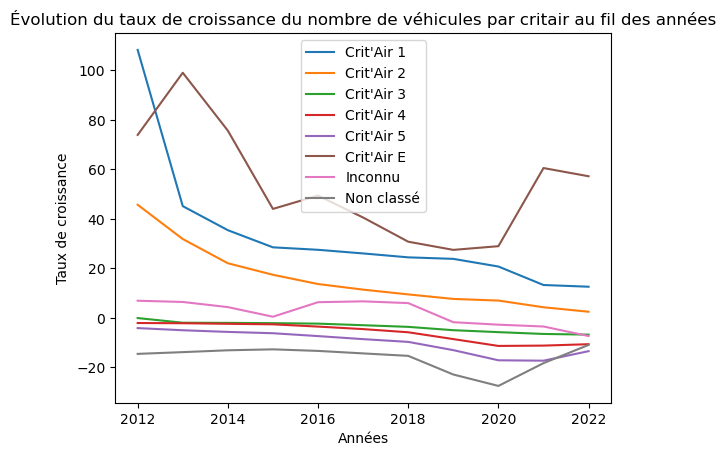

In [29]:
Années=[2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022]
i=0
for c in taux_de_croissance.index:
    v=taux_de_croissance.iloc[i]
    v=v[1:]
    plt.plot(Années,v, label=c)
    i+=1
    
# Ajout des titres et légendes
plt.title('Évolution du taux de croissance du nombre de véhicules par critair au fil des années')
plt.xlabel('Années')
plt.ylabel('Taux de croissance')
plt.legend()
plt.show()

Il serait interessant de pouvoir prédire le taux de croissance jusqu'en 2035 ou 2050 !

In [30]:
#J'aimerais pouvoir comparer en fonction du type de véhicule, de la vignette critair et du carburant pour chaque région 
#afin de faire une carte interractive

In [31]:
#Quel est le carburant dominant dans chaque région?
count_df =data.groupby(["REGION_LIBELLE",'CARBURANT']).size().reset_index(name="Count")
count_df.head()

,REGION_LIBELLE,CARBURANT,Count
0,Auvergne-Rhône-Alpes,Diesel,1751
1,Auvergne-Rhône-Alpes,Diesel HNR,123
2,Auvergne-Rhône-Alpes,Electrique et hydrogène,286
3,Auvergne-Rhône-Alpes,Essence,749
4,Auvergne-Rhône-Alpes,Essence HNR,128


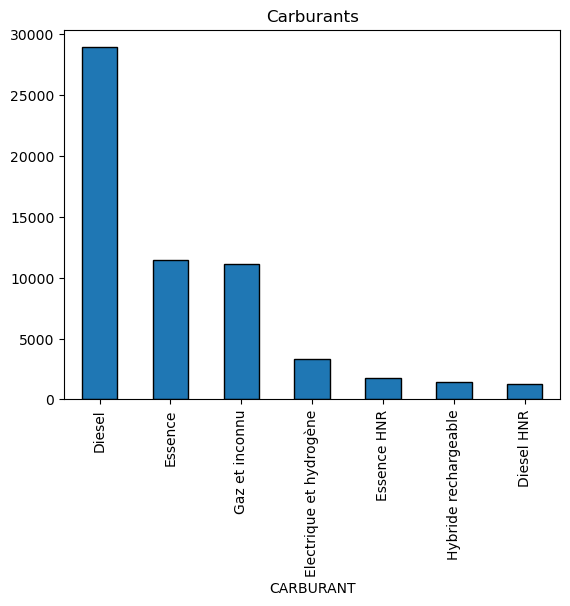

In [32]:
#Répartition des différents carburants dans notre échantillon
data['CARBURANT'].value_counts().plot(kind='bar', edgecolor='black')
plt.title("Carburants")
plt.show()

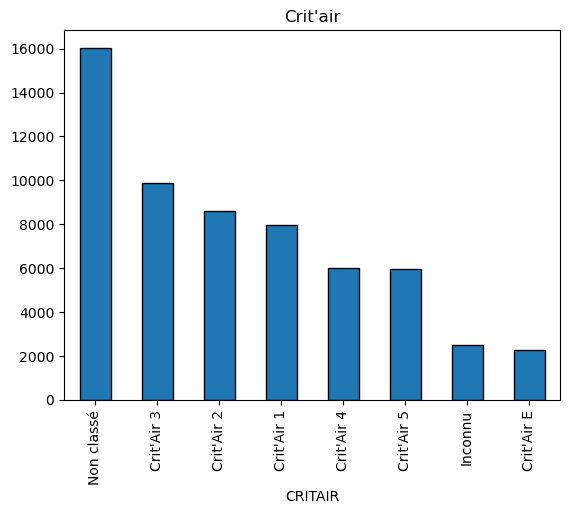

In [33]:
#Répartition des différentes vignettes critair dans notre échantillon:
data['CRITAIR'].value_counts().plot(kind='bar', edgecolor='black')
plt.title("Crit'air")
plt.show()

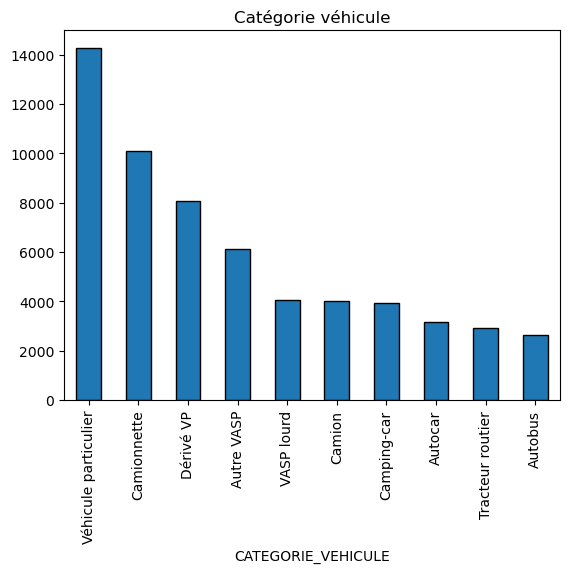

In [34]:
data['CATEGORIE_VEHICULE'].value_counts().plot(kind='bar', edgecolor='black')
plt.title("Catégorie véhicule")
plt.show()

## Île-de-France

In [35]:
iledefrance=data.loc[data['REGION_LIBELLE']=="Île-de-France"].copy()
iledefrance.head()

,REGION_CODE,REGION_LIBELLE,CLASSE_VEHICULE,CATEGORIE_VEHICULE,CARBURANT,AGE,STATUT_UTILISATEUR,CRITAIR,PARC_2011,PARC_2012,PARC_2013,PARC_2014,PARC_2015,PARC_2016,PARC_2017,PARC_2018,PARC_2019,PARC_2020,PARC_2021,PARC_2022
5390,11,Île-de-France,tcp,Autobus,Diesel,0 an,Professionnel,Crit'Air 2,0,0,0,42,529,403,251,315,489,213,212,83
5391,11,Île-de-France,tcp,Autocar,Diesel,0 an,Professionnel,Crit'Air 2,0,0,0,10,823,1264,1253,1175,1160,1246,930,784
5392,11,Île-de-France,tcp,Autobus,Diesel,0 an,Professionnel,Crit'Air 3,539,632,553,568,88,9,0,0,0,0,0,0
5393,11,Île-de-France,tcp,Autocar,Diesel,0 an,Professionnel,Crit'Air 3,969,1264,1031,1054,310,26,9,1,0,0,0,0
5394,11,Île-de-France,tcp,Autocar,Diesel,0 an,Professionnel,Crit'Air 4,8,0,0,0,0,0,0,0,0,0,0,0


## Attribution des vignettes crit'air

In [36]:
def attribuer_vignette_critair(age,carburant):
    # Logique de votre attribution de vignette en fonction des caractéristiques du véhicule
    if carburant== "Electrique et hydrogène":
        return "Crit'Air E"
    elif carburant =="Hybride rechargeable" or carburant=="Gaz et inconnu":
        return "Crit'Air 1"
    elif carburant =="Essence" or carburant =="Essence HNR":
        if age > 26:
            return "Non classé"
        elif age <=26 and age >=18 :
            return "Crit'Air 3"
        elif age <=17 and age >=13 :
            return "Crit'Air 2"
        else :
            return "Crit'Air 1"
    
    elif carburant == "Diesel" or carburant =="Diesel HNR":
        if age > 26:
            return "Non classé"
        elif age <26 and age >=23 :
            return "Crit'Air 5"
        elif age <23 and age >=18 :
            return "Crit'Air 4"
        elif age <18 and age >=13 :
            return "Crit'Air 3"
        elif age <13:
            return "Crit'Air 2"

In [37]:
attribuer_vignette_critair(3,'Electrique et hydrogène')

"Crit'Air E"

## Modélisation de l'évolution du parc automobile

In [40]:
#D'après les études précédentes nous savons les taux de croissances suivant:

#taux_de_croissance['Mean']=taux_de_croissance.mean(axis=1)
taux_de_croissance=taux_de_croissance.drop('PARC_2011', axis=1).copy() #On retire les valeurs NA

In [41]:
taux_de_croissance

,PARC_2012,PARC_2013,PARC_2014,PARC_2015,PARC_2016,PARC_2017,PARC_2018,PARC_2019,PARC_2020,PARC_2021,PARC_2022
CRITAIR,,,,,,,,,,,
Crit'Air 1,108.243636,45.119843,35.399273,28.477689,27.475794,26.011101,24.429136,23.814267,20.720877,13.254197,12.563480
Crit'Air 2,45.676683,31.832596,22.043066,17.382701,13.644911,11.382808,9.453850,7.627566,6.965519,4.258114,2.453101
Crit'Air 3,-0.105313,-1.986853,-2.044485,-2.161928,-2.355781,-2.994557,-3.657818,-5.008641,-5.793061,-6.524667,-6.798498
Crit'Air 4,-2.110095,-2.191197,-2.423704,-2.632523,-3.548981,-4.564904,-5.845677,-8.601442,-11.363451,-11.233444,-10.666583
Crit'Air 5,-4.154789,-5.029678,-5.699676,-6.232216,-7.390773,-8.623128,-9.732246,-13.064001,-17.168324,-17.327904,-13.477294
Crit'Air E,73.904639,99.024330,75.625194,44.000424,49.390259,40.516392,30.753226,27.445424,28.937382,60.514533,57.197859
Inconnu,6.896552,6.398731,4.324056,0.428776,6.309298,6.648817,5.941423,-1.777251,-2.774427,-3.515302,-7.372482
Non classé,-14.576259,-13.870731,-13.128377,-12.744372,-13.377475,-14.384744,-15.375230,-22.912174,-27.524526,-18.329127,-10.951793


In [44]:
#On va tenter de prédire le taux de croissance pour chaque vignette crit'air à l'aide d'une régression linéaire:
annees = annees = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10,11])
annees = annees.reshape(-1, 1)
modele = LinearRegression()
annee_future = 12

def prediction(i):
    # Ajustez le modèle aux données d'entraînement
    modele.fit(annees, taux_de_croissance.iloc[i])
    
    # Prédisez le taux de croissance pour une année future
    taux_predit = modele.predict([[annee_future]])
    
    # Affichez les résultats
    print(f"Taux de croissance prédit pour l'année {annee_future}: {taux_predit[0]}")

    # Affichez les données d'origine et la ligne de régression
    plt.scatter(annees, taux_de_croissance.iloc[i], label='Données historiques')
    plt.plot(annees, modele.predict(annees), color='red', label='Régression linéaire')
    plt.scatter(annee_future, taux_predit, color='green', marker='x', label=f'Prédiction pour {annee_future}')
    plt.xlabel('Années')
    plt.ylabel('Taux de croissance')
    plt.legend()
    plt.show()

Taux de croissance prédit pour l'année 12: -2.895813101598293


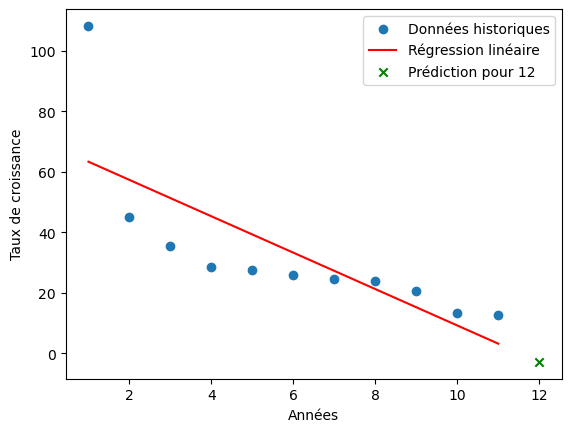

In [45]:
prediction(0)

Prédiction pour Crit'Air 1
Taux de croissance prédit pour l'année 12: -2.895813101598293


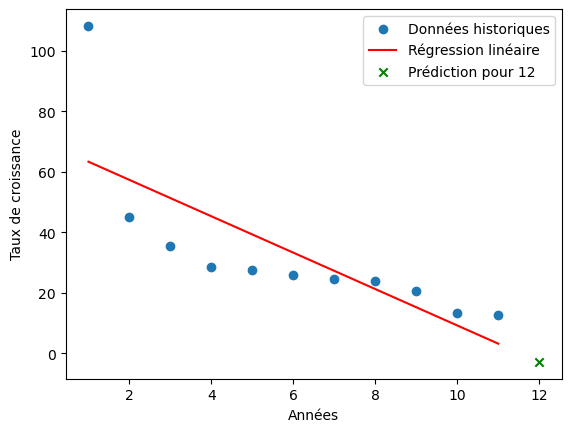

Prédiction pour Crit'Air 2
Taux de croissance prédit pour l'année 12: -5.862633937964702


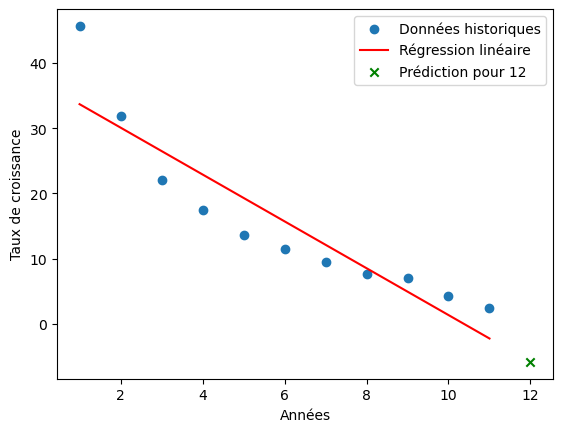

Prédiction pour Crit'Air 3
Taux de croissance prédit pour l'année 12: -7.395147775033973


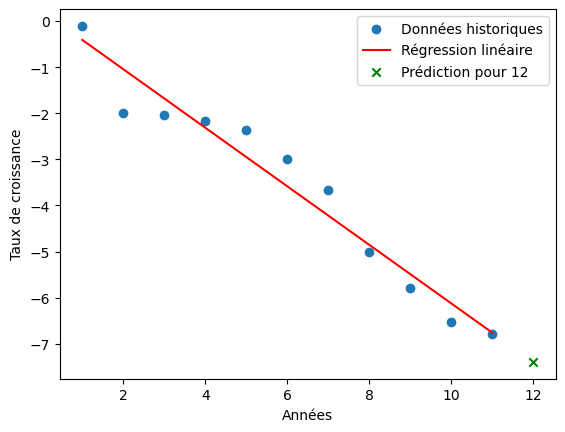

Prédiction pour Crit'Air 4
Taux de croissance prédit pour l'année 12: -12.471374998921284


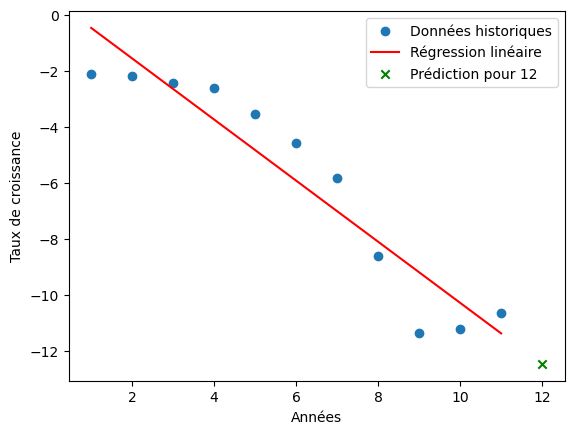

Prédiction pour Crit'Air 5
Taux de croissance prédit pour l'année 12: -17.78453433820695


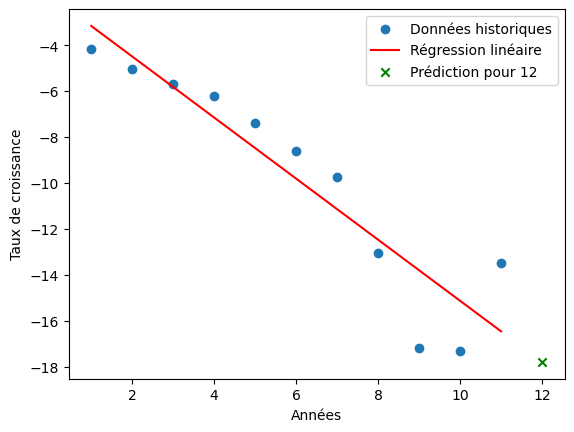

Prédiction pour Crit'Air E
Taux de croissance prédit pour l'année 12: 29.970866396706484


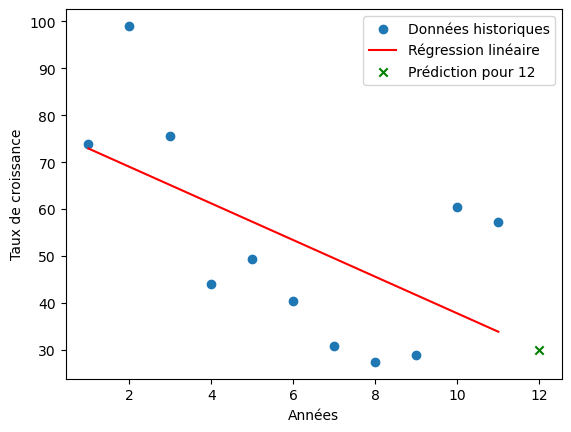

Prédiction pour Inconnu
Taux de croissance prédit pour l'année 12: -5.5216195746969206


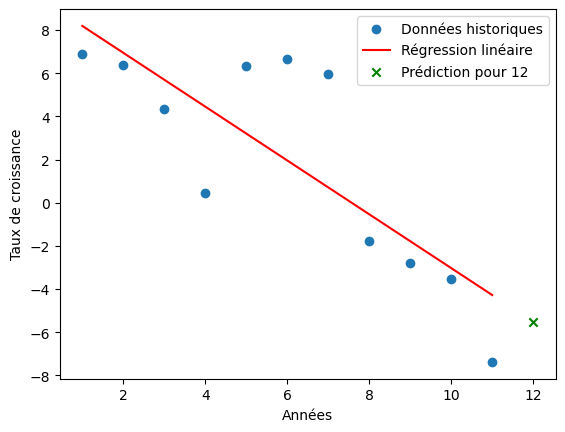

Prédiction pour Non classé
Taux de croissance prédit pour l'année 12: -19.6649675316322


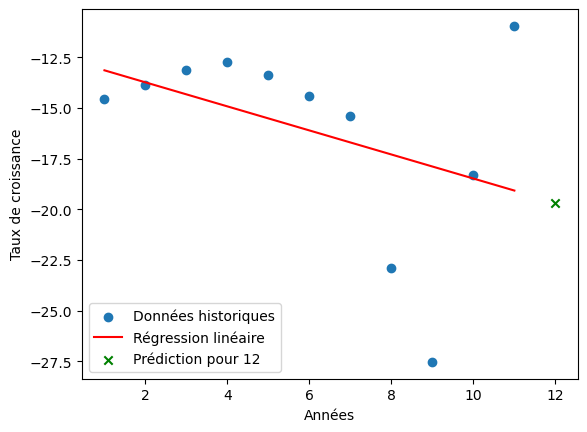

In [55]:
for i in range (0,8):
    print(f'Prédiction pour {taux_de_croissance.index[i]}') 
    prediction(i)

In [56]:
annee_future=np.arange(12,25)
taux2022=taux_de_croissance['PARC_2022'].copy()
taux2022=pd.DataFrame(taux2022)

def prediction_dataframe():
    for k in annee_future:
        n=np.zeros(8)
        for i in range (0,8):
            modele.fit(annees, taux_de_croissance.iloc[i])
            taux=modele.predict([[k]])
            n[i]=taux
        taux2022[f'PARC_20{k+11}']=n
    return taux2022

In [57]:
taux_de_croissance_predit=prediction_dataframe()
taux_de_croissance_predit


/tmp/ipykernel_245/1219056733.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  n[i]=taux
/tmp/ipykernel_245/1219056733.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  n[i]=taux
/tmp/ipykernel_245/1219056733.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  n[i]=taux
/tmp/ipykernel_245/1219056733.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from yo

,PARC_2022,PARC_2023,PARC_2024,PARC_2025,PARC_2026,PARC_2027,PARC_2028,PARC_2029,PARC_2030,PARC_2031,PARC_2032,PARC_2033,PARC_2034,PARC_2035
CRITAIR,,,,,,,,,,,,,,
Crit'Air 1,12.563480,-2.895813,-8.916468,-14.937123,-20.957778,-26.978433,-32.999089,-39.019744,-45.040399,-51.061054,-57.081709,-63.102364,-69.123019,-75.143674
Crit'Air 2,2.453101,-5.862634,-9.456723,-13.050812,-16.644902,-20.238991,-23.833080,-27.427169,-31.021258,-34.615348,-38.209437,-41.803526,-45.397615,-48.991705
Crit'Air 3,-6.798498,-7.395148,-8.030224,-8.665300,-9.300376,-9.935452,-10.570528,-11.205604,-11.840681,-12.475757,-13.110833,-13.745909,-14.380985,-15.016061
Crit'Air 4,-10.666583,-12.471375,-13.562331,-14.653288,-15.744244,-16.835201,-17.926157,-19.017113,-20.108070,-21.199026,-22.289983,-23.380939,-24.471895,-25.562852
Crit'Air 5,-13.477294,-17.784534,-19.113775,-20.443015,-21.772255,-23.101495,-24.430735,-25.759975,-27.089215,-28.418456,-29.747696,-31.076936,-32.406176,-33.735416
Crit'Air E,57.197859,29.970866,26.067380,22.163893,18.260406,14.356919,10.453432,6.549945,2.646458,-1.257028,-5.160515,-9.064002,-12.967489,-16.870976
Inconnu,-7.372482,-5.521620,-6.767771,-8.013923,-9.260074,-10.506226,-11.752378,-12.998529,-14.244681,-15.490832,-16.736984,-17.983136,-19.229287,-20.475439
Non classé,-10.951793,-19.664968,-20.257995,-20.851023,-21.444051,-22.037079,-22.630107,-23.223134,-23.816162,-24.409190,-25.002218,-25.595246,-26.188273,-26.781301


Text(0.5, 1.0, "Estimation du taux de croissance pour les crit'air inconnu (6)")

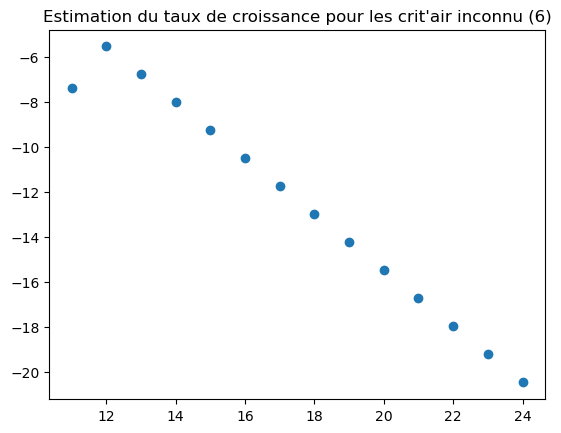

In [59]:
a=np.arange(11,25)
plt.scatter(a, taux_de_croissance_predit.iloc[6], label='Données historiques')
plt.title("Estimation du taux de croissance pour les crit'air inconnu (6)")

In [109]:
k=15
n=np.zeros(8)
for i in range (0,8):
            modele.fit(annees, taux_de_croissance.iloc[i])
            taux=modele.predict([[k]])
            print(taux)
            n[i]=taux
print(n)
taux_de_croissance[f'PARC_20{k+11}']=n

[-20.95777839]
[-16.64490158]
[-9.30037611]
[-15.7442442]
[-21.77225483]
[18.26040584]
[-9.26007436]
[-21.44405097]
[-20.95777839 -16.64490158  -9.30037611 -15.7442442  -21.77225483
  18.26040584  -9.26007436 -21.44405097]


/var/folders/0d/wtg1_x4x6vgglvz6ksylz56c0000gn/T/ipykernel_1948/3578568135.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  n[i]=(taux)
/var/folders/0d/wtg1_x4x6vgglvz6ksylz56c0000gn/T/ipykernel_1948/3578568135.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  n[i]=(taux)
/var/folders/0d/wtg1_x4x6vgglvz6ksylz56c0000gn/T/ipykernel_1948/3578568135.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  n[i]=(taux)
/var/folders/0d/wtg1_x4x6vgglvz6ksylz56c0000gn/T/ipy

## Estimation du modèle probabilistique

In [ ]:
# Définir les paramètres de la distribution binomiale
n = 10  # Nombre d'essais
p = 0.5  # Probabilité de succès

# Générer des variables aléatoires binomiales
donnees_aleatoires = binom.rvs(n=n, p=p, size=1000)

# Calculer la probabilité d'obtenir k succès
k = 5
probabilite_k_succes = binom.pmf(k, n, p)

# Calculer la fonction de répartition (CDF) jusqu'à k
cdf_k = binom.cdf(k, n, p)

# Afficher les résultats
print("Données aléatoires binomiales :", donnees_aleatoires)
print(f"Probabilité d'obtenir {k} succès :", probabilite_k_succes)
print(f"CDF jusqu'à {k} succès :", cdf_k)

## Représentation graphique

In [ ]:
france = download_vectorfile_url_all(
      values = "metropole",
      crs = 4326,
      borders = "REGION",
      vectorfile_format="topojson",
      filter_by="FRANCE_ENTIERE",
      source="EXPRESS-COG-CARTO-TERRITOIRE",
      year=2022)

In [ ]:
france.head()

In [ ]:
#base=france.boundary.plot(edgecolor="black", linewidth=0.5)

In [ ]:
#merged = france.set_index('NOM').join(data.set_index('REGION_LIBELLE'))

# Créer une carte
#fig, ax = plt.subplots(1, 1, figsize=(10, 10))
#merged.plot(column='CARBURANT', cmap='coolwarm', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

# Ajouter une légende
#ax.legend(title='Carburant', loc='upper left', bbox_to_anchor=(1, 1))